# Clustering Social Media Data

In [801]:
#!pip install umap-learn
#python -m pip install umap

In [5]:
import numpy as np
import pandas as pd
import pickle
from os import path as Path
import datetime
import numpy as np
from sklearn import datasets
import json
import ast 							# for conversion of parameters to desired formats 
from sklearn.metrics.pairwise import cosine_similarity

# Plotting libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension-reduction and clustering libs
import sklearn
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

#import umap.umap_ as umap
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'oh', 'mebank','um','umm','ummm','hi','hello','hey','heyyyyy','fyi','000'])

In [7]:
input_data=pd.read_pickle("../data/mebank_tweets_1_year_embeddings.pkl")
input_data.tail(1)

,date,content,content_clean,complaint,topic,embedding
832,2021-07-25 09:22:13,Making beautiful banking and helping Australi...,making beautiful banking and helping australia...,0,NaN,"[-0.13470693, 0.11104454, 0.031296838, 0.06003..."


# Data Statistics

In [8]:
input_data.describe()

,complaint
count,833.000000
mean,0.368547
std,0.482701
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
input_data["topic"]=input_data['topic'].fillna('NA')
input_data["topic"].value_counts()

NA                            516
problem/customer service       74
problem/system down            70
problem/others                 50
problem/app                    33
problem/transaction            31
problem/financial products     29
inquiry                         7
feature request                 7
problem/website                 5
others                          5
problem/atm                     2
fraud                           2
sustainability                  2
Name: topic, dtype: int64

# Splitting the data


Splitting the data for unsupervised clustering (comparing over time)

In [10]:
# convert date from str to date format
input_data['date']=input_data['date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
type(input_data['date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [7]:
input_data_base = input_data[(input_data['date']> datetime.datetime(year=2020,month=1,day=1)) \
	& (input_data['date']< datetime.datetime(year=2021,month=4,day=1))].reset_index()

input_data_new = input_data[(input_data['date']>= datetime.datetime(year=2021,month=4,day=1))].reset_index()
input_data_new.head()


,index,date,content,content_clean,complaint,topic,embedding
0,592,2021-04-01 03:02:20,"No, I do not recommend @mebank to anyone.","no, i do not recommend to anyone.",1,problem/others,"[-0.013402059, 0.3395726, -0.0548299, 0.049085..."
1,593,2021-04-01 03:43:04,@mebank I have DMed you my issue.,i have dmed you my issue.,0,NA,"[-0.0322621, -0.050013743, -0.061552726, -0.03..."
2,594,2021-04-01 12:31:17,I can receive an instant transfer from another...,i can receive an instant transfer from another...,1,problem/transaction,"[0.1503182, 0.0052553327, 0.013878645, -0.0448..."
3,595,2021-04-01 23:40:12,@Zed_i T*meBank gives 8% (starts at 4% and inc...,t*mebank gives % (starts at % and increases ev...,0,NA,"[-0.13633932, -0.22206554, -0.1001978, -0.0212..."
4,596,2021-04-06 00:00:52,Finalists of the 2021 HESTA Australian Nursing...,finalists of the hesta australian nursing &amp...,0,NA,"[-0.0667103, 0.08258438, -0.15451492, -0.09570..."


In [8]:
input_data_base=input_data.sample(300).reset_index()
input_data_new=input_data.sample(300).reset_index()

In [11]:
input_data_base=input_data[input_data["topic"].isin(["problem/customer service","problem/app","problem/others","inquiry","others"])].reset_index()
input_data_new=input_data[input_data["topic"].isin(["problem/customer service","problem/system down","problem/app","feature request","problem/financial products","sustainability"])].reset_index()
input_data_new.head(5)

,index,date,content,content_clean,complaint,topic,embedding
0,5,2020-07-29 11:13:18,@HESTASuper @mebank Don‚Äôt bank with @MEBank....,dont bank with . i was a loyal customer for yr...,1,problem/financial products,"[-0.10862947, -0.0903867, 0.036242366, 0.10042..."
1,6,2020-07-29 11:13:30,@mebank Don‚Äôt bank with @MEBank. I was a loy...,dont bank with . i was a loyal customer for yr...,1,problem/financial products,"[-0.10862947, -0.0903867, 0.036242366, 0.10042..."
2,7,2020-07-29 11:16:32,@mebank @James57136915 Do not bank with @meban...,do not bank with . dishonest and greedy.,1,problem/customer service,"[-0.101497136, 0.29077035, -0.022145595, 0.221..."
3,22,2020-08-01 03:25:35,@mebank You have some of the slowest customer ...,you have some of the slowest customer support....,1,problem/customer service,"[0.07929769, 0.103091285, -0.06687362, -0.0067..."
4,23,2020-08-02 04:26:27,Hey @mebank when are you going to enable Googl...,hey when are you going to enable google pay? y...,1,problem/financial products,"[0.01757788, 0.14083667, -0.016933978, -0.0333..."


In [809]:
# saving splitted data
#input_data_2020.to_csv("../data/mebank_tweets_2020_embedding.csv", index=False)
#input_data_2021.to_csv("../data/mebank_tweets_2021_embedding.csv", index=False)

#input_data_2020.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_2020_embedding.csv", index=False)
#input_data_2021.to_csv(f"{s3_data_dir}/preprocessed/mebank_tweets_2021_embedding.csv", index=False)

# Dimentionality Reduction

In [12]:
pca_model_base=PCA(n_components=10)
pca_model_new=PCA(n_components=10)

pca_model_base.fit(input_data_base['embedding'].values.tolist())
pca_model_new.fit(input_data_new['embedding'].values.tolist())

PCA(n_components=10)

In [13]:
kpca_model_base=KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=10)
kpca_model_new=KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=10)
#kpca_model_new=KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=20, gamma=10)

kpca_model_base.fit(input_data_base['embedding'].values.tolist())
kpca_model_new.fit(input_data_new['embedding'].values.tolist())

KernelPCA(fit_inverse_transform=True, kernel='rbf', n_components=10)

In [ ]:
# cannot be used directly as it does not accept negative features
nmf_model_base=NMF(n_components=10, init='random', random_state=0)
nmf_model_new=NMF(n_components=10, init='random', random_state=0)

nmf_model_base.fit(input_data_base['embedding'].values.tolist())
nmf_model_new.fit(input_data_new['embedding'].values.tolist())

In [15]:
isomap_model_base=Isomap(n_components=10)
isomap_model_new=Isomap(n_components=10)

isomap_model_base.fit(input_data_base['embedding'].values.tolist())
isomap_model_new.fit(input_data_new['embedding'].values.tolist())

Isomap(n_components=10)

In [16]:
se_model_base=SpectralEmbedding(n_components=10)
se_model_new=SpectralEmbedding(n_components=10)

se_model_base.fit(input_data_base['embedding'].values.tolist())
se_model_new.fit(input_data_new['embedding'].values.tolist())

SpectralEmbedding(n_components=10)

In [17]:
lle_model_base=LocallyLinearEmbedding(n_components=10)
lle_model_new=LocallyLinearEmbedding(n_components=10)

lle_model_base.fit(input_data_base['embedding'].values.tolist())
lle_model_new.fit(input_data_new['embedding'].values.tolist())

LocallyLinearEmbedding(n_components=10)

UMAP Model

In [19]:
# Define UMAP model to reduce embeddings dimension 
n_neighbors=15    #smaller -> more local, larger: global structure, more uniform density
n_components=10    
min_dist=0.01      # min distance in projected space (0 or small value)

umap_model_base = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=42,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1 #giving keeping densities some weight
                       )

umap_model_new = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=42,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1                     
                       )

umap_model_all = umap.UMAP(n_neighbors=n_neighbors,
                       random_state=42,
                       n_components=n_components,
                       min_dist=min_dist,
                       metric='cosine',
                       low_memory=False,
                       #densmap=True, 
                       #dens_lambda=0.1                     
                       )                      

In [ ]:
umap_model_base.fit_transform(input_data_base['embedding'].values.tolist())
umap_model_new.fit_transform(input_data_new['embedding'].values.tolist())

Visualizing projections

In [21]:
def vis_mapping(data, labels=None, model=None, n_components=2, n_samples=10, title=''):

    if model != None:
        u = model.transform(data)
    else:
        u = np.array(data)
    
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,1], range(len(u)), c=range(len(data)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=range(len(data)))
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=range(len(data)), s=100)
    plt.title(title, fontsize=18)

    if type(labels) == np.ndarray:
        labels = pd.DataFrame(labels,columns=['topic'])


    #labels
    if not labels.empty :
        #samples=labels[labels.isin(["problem/app","feature request","sustainability"])]
        samples=labels.sample(n_samples)
        for i in range(len(samples)):
            label = "{}".format(samples.values[i])
            #print(i,samples.index[i],label)

            plt.annotate(label, # this is the text
                        (u[samples.index[i],0], u[samples.index[i],1]), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,0.5), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

        plt.show()

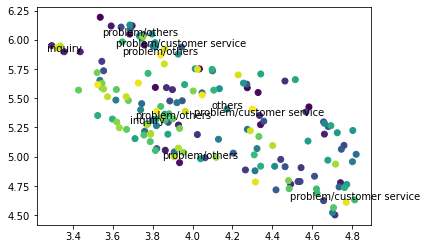

In [22]:
data=input_data_base['embedding'].values.tolist()
labels=input_data_base['topic']
vis_mapping(data, labels=labels, model=umap_model_base, n_components=2)

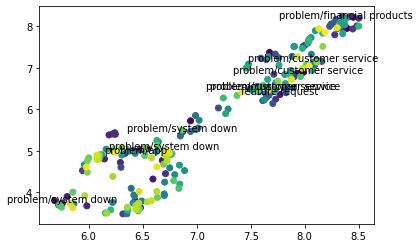

In [23]:
data=input_data_new['embedding'].values.tolist()
labels=input_data_new['topic']
vis_mapping(data, labels=labels, model=umap_model_new, n_components=2)

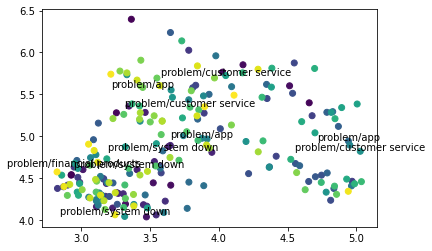

In [25]:
data=input_data_new['embedding'].values.tolist()
labels=input_data_new['topic']
vis_mapping(data, labels=labels, model=umap_model_base, n_components=2)

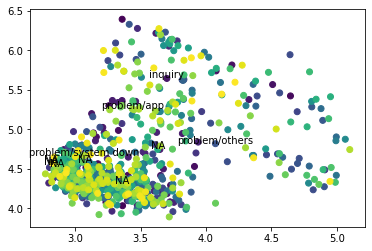

In [26]:
data=input_data['embedding'].values.tolist()
labels=input_data['topic']
vis_mapping(data, labels=labels, model=umap_model_base, n_components=2)

Projecting embeddings into lower dimentional space (using kpca, pca, UMAP, or ...)

In [27]:
#selecting the projection method 
reducer_base=umap_model_base
reducer_new=umap_model_new

#projecting data using selected method
projections_base=reducer_base.transform(input_data_base['embedding'].values.tolist())
projections_new=reducer_new.transform(input_data_new['embedding'].values.tolist())

In [ ]:
#umap_embeddings_base=umap_model_base.embedding_
#umap_embeddings_new=umap_model_new.embedding_
#umap_embeddings_cross=umap_model_base.transform(input_data_new['embedding'].values.tolist())

In [767]:
#import sys 
#sys.path.insert(1, '../scripts')
#from RankedPoints import RankedPoints

# Clustering

HDBSCAN Model

In [29]:
# Define HDBSCAN model to perform documents clustering

# Parameters: 
# (a) min_cluster_size: min cluster size
# (b) min_sample: the larger the value of min_samples you provide, the more conservative the clustering 
#    – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. 
# (c): cluster_selection_epsilon=epsilon, #useful to avoid micro-clusters when we have different densities and small min_cluster size
# (d) cluster_selection_method: eom (stability based) or leaf

epsilon_base=0.4
min_cluster_size_base=5
min_samples_base=2

epsilon_new=0.3
min_cluster_size_new=5
min_samples_new=2

hdbscan_model_base = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_base,
                                min_samples=min_samples_base,
                                metric='euclidean',
                                cluster_selection_epsilon=epsilon_base, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )

hdbscan_model_new = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_new,
                                min_samples=min_samples_new,
                                metric='euclidean',
                                cluster_selection_epsilon=epsilon_new, #useful to avoid micro-clusters when we have different densities and small min_cluster size
                                cluster_selection_method='eom',
                                prediction_data=True,
                                )


Clusterin embeddings directly (not recommended, hdbscan is suitable for upto 50 or max 100 features)

In [282]:
#hdbscan_cluster_base = hdbscan_model_base.fit(input_data_base['embedding'].values.tolist())
#hdbscan_cluster_new = hdbscan_model_new.fit(input_data_new['embedding'].values.tolist())

Clusterin projections using HDBSAN

In [31]:
hdbscan_clusterer_base = hdbscan_model_base.fit(projections_base)
hdbscan_clusterer_new = hdbscan_model_new.fit(projections_new)


Visualizing clusters to adjust parameters

<AxesSubplot:ylabel='distance'>

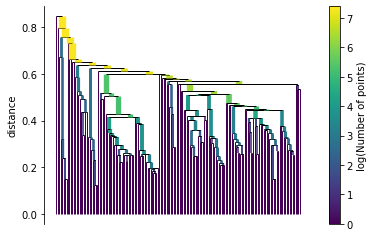

In [33]:
#hdbscan_cluster_base.condensed_tree_.plot()
hdbscan_clusterer_base.single_linkage_tree_.plot()

<AxesSubplot:ylabel='distance'>

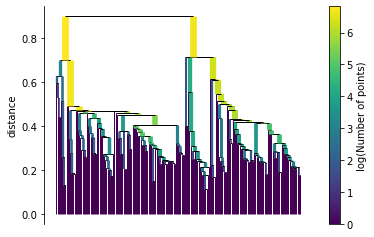

In [34]:
hdbscan_clusterer_new.single_linkage_tree_.plot()

In [486]:
#cluster_labels=hdbscan_cluster.single_linkage_tree_.get_clusters(0.4, min_cluster_size=5)
#cluster_labels

In [35]:
print(hdbscan_clusterer_base.labels_[:200])
print(hdbscan_clusterer_new.labels_[:200])

[ 7  9  6 10 10 -1  8  6  4  7  7  7  1  9  5 11  0  0  0 -1  3  6 -1  1
 11  9  1 -1  8  0 -1  8 -1  8 11  6  7  9  9 -1  5 10  8  8  1  6  3  9
  9 -1  7  6 -1  3 11  4  4 -1 -1  9 -1  4  1 -1  2  2  3 -1  1  5  5 11
  1 11 -1  7  5  9  7  7 -1 -1  6  6  6  1  7 -1  7 -1  6 11 11 10  2 -1
 -1  9  4 -1  6  6  9 -1 -1 11  4  6  4  7  6 -1 -1 11 11 -1 11  4 -1  2
  2  4  4 11 11  2  5  4  5  8  5  5  5  5 11  5  3  4  6  4  4 -1  2  4
  5 11  4  4  4  8  4  0  4  5  1  3  8  6 -1 -1  0 -1 11 -1  5  5  3 10
  7]
[12 12 12 -1  0 11  4  4  4  3 10 10 -1 -1  9  9 -1  5 -1 13  3  3 10 10
 13 -1  3 -1  3 -1  6  9 12 12 12 12 12 12 12  7  1  4 14  7  5 10 11  3
  6  5 -1  8  6  2  2  7 12 12  2  2  7 12 12 12 -1  8  8 12  2  2  6 -1
  5  0  8  0  0  0 -1  0 13 14  9 -1  6  5  7  5 13  9 14 14 -1  9 13 10
 -1 -1  8 -1  1  5  0 -1  7  3  9  1  1  4  6  7  3  1 11  8  9 -1 12  8
 12 -1 11  4  4  4 12 12 12  0  7 -1 14  5 11 11  8  0  7 14 11 -1 12 11
  7  7 -1  7 14 -1  9 13 -1 14 10 10 14  9 -1 

In [37]:
hdbscan_clusterer_predicted_labels, hdbscan_clusterer_predicted_strengths = hdbscan.approximate_predict(hdbscan_clusterer_base, projections_cross)
#hdbscan_cluster_cross_labels, hdbscan_cluster_cross_strengths = hdbscan.approximate_predict(hdbscan_cluster_base, input_data_new['embedding'].values.tolist())

#hdbscan_cluster_2020_2021_fit = hdbscan_model_2020.fit_predict(umap_embeddings_2021[-200:])

print(hdbscan_clusterer_predicted_labels[:200])

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 -1 -1 -1 -1 -1
  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  7 -1
 -1 -1 -1 -1  4 -1 -1 -1  2  2 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1  5 -1  5
 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [38]:
hdbscan_clusterer_base.cluster_persistence_
#sum(hdbscan_cluster_1year.cluster_persistence_)


array([0.2951557 , 0.10491286, 0.3634341 , 0.0616204 , 0.20527796,
       0.38028846, 0.17481425, 0.34841901, 0.21264443, 0.19197225,
       0.        , 0.0944685 ])

In [26]:
output_base=input_data_base
output_base['cluster']=hdbscan_cluster_base.labels_
output_base['cluster_probability']=hdbscan_cluster_base.probabilities_
output_base['outlier_score']=hdbscan_cluster_base.outlier_scores_

In [27]:
output_base=output_base.sort_values(by="cluster")
output_base[100:110]

,index,date,content,content_clean,complaint,topic,embedding,cluster,cluster_probability,outlier_score
2,33,2020-08-04 02:57:09,@mebank I'm trying again today. I think you sh...,i'm trying again today. i think you should imp...,1,problem/customer service,"[0.03748599, 0.051713225, 0.019333068, -0.0435...",2,1.000000,0.229188
1,22,2020-08-01 03:25:35,@mebank You have some of the slowest customer ...,you have some of the slowest customer support....,1,problem/customer service,"[0.07929769, 0.103091285, -0.06687362, -0.0067...",2,1.000000,0.205129
37,229,2020-11-09 06:10:55,"@mebank Great, but how about having enough sta...","great, but how about having enough staff to an...",1,problem/customer service,"[0.09882341, 0.27586764, -0.07393702, -0.07073...",2,1.000000,0.066992
38,230,2020-11-09 06:13:46,@mebank @Canstar You won't have the best custo...,you won't have the best customers if you don't...,1,problem/customer service,"[0.07501819, 0.10478912, -0.008794743, -0.1083...",2,1.000000,0.018079
168,831,2021-07-24 01:09:02,So @mebank made me come all the way to police ...,so made me come all the way to police station ...,1,problem/others,"[-0.028286709, -0.125497, 0.05789608, 0.124763...",2,0.997719,0.002281
54,322,2020-12-26 06:02:53,Waited nearly 5hrs until call centre closed wi...,waited nearly hrs until call centre closed wit...,1,problem/customer service,"[0.0025381031, 0.058599927, -0.13217606, -0.06...",2,1.000000,0.116699
53,321,2020-12-26 03:49:02,Been on hold to @mebank for 160mins. Should ha...,been on hold to for mins. should have closed m...,1,problem/customer service,"[-0.016193414, 0.041359834, 0.003774949, -0.04...",2,1.000000,0.001660
58,347,2021-01-05 00:47:14,@Antonius0_0 @88888sAccount Is $110 mil how mu...,is $110 mil how much money took out of peoples...,1,problem/others,"[-0.12948844, 0.3266891, 0.021654038, 0.199442...",2,1.000000,0.009519
59,348,2021-01-05 06:57:00,@mebank Would be a better 2021 if you did some...,would be a better if you did something about y...,1,problem/customer service,"[0.09160534, 0.20534082, -0.17476973, -0.06230...",2,1.000000,0.355330
51,319,2020-12-24 12:01:14,@mebank @Trigz74417108 Can I make a suggestion...,can i make a suggestion that me bank should ma...,1,problem/customer service,"[0.013413943, -0.06426583, -0.00057072827, 0.0...",2,1.000000,0.171767


In [28]:
output_new=input_data_new
output_new['cluster_base']=hdbscan_cluster_cross_labels
output_new['cluster']=hdbscan_cluster_new.labels_
output_new['cluster_probability']=hdbscan_cluster_new.probabilities_
output_new['outlier_score']=hdbscan_cluster_new.outlier_scores_

In [29]:
output_new=output_new.sort_values(by="cluster")
output_new[100:110]

,index,date,content,content_clean,complaint,topic,embedding,cluster_base,cluster,cluster_probability,outlier_score
6,35,2020-08-05 08:28:27,"No way @mebank, I hadn't noticed since it's on...","no way , i hadn't noticed since it's only been...",1,problem/customer service,"[0.02779619, 0.28380167, -0.011434564, -0.1270...",-1,0,1.000000,0.003613
56,206,2020-11-03 05:09:49,Pls pass on rate cut immediately @mebank or Im...,pls pass on rate cut immediately or im heading...,1,problem/financial products,"[-0.23861963, -0.27140757, -0.020297915, -0.03...",-1,0,1.000000,0.000000
61,222,2020-11-06 23:44:24,@mebank Do not trust this bank. They jacked my...,do not trust this bank. they jacked my home lo...,1,problem/financial products,"[-0.17138223, -0.020126317, 0.0018054675, 0.05...",-1,0,1.000000,0.004994
62,223,2020-11-06 23:46:55,@mebank AVOID this bank. They treat their cust...,avoid this bank. they treat their customers ba...,1,problem/customer service,"[-0.11939178, 0.011397157, -0.006311967, 0.082...",-1,0,1.000000,0.000000
63,224,2020-11-06 23:49:19,@mebank @Canstar What NONSENSE. This is the wo...,what nonsense. this is the worst bank ever. im...,1,problem/financial products,"[-0.092518285, -0.20418626, -0.03176387, 0.045...",-1,0,1.000000,0.107609
64,225,2020-11-06 23:50:30,"@mebank If you repaid me the $1,000 you ripped...","if you repaid me the $1,000 you ripped off fro...",1,problem/financial products,"[0.043063905, 0.04174897, -0.03205841, 0.14265...",-1,0,1.000000,0.019302
65,229,2020-11-09 06:10:55,"@mebank Great, but how about having enough sta...","great, but how about having enough staff to an...",1,problem/customer service,"[0.09882341, 0.27586764, -0.07393702, -0.07073...",-1,0,1.000000,0.000000
1,6,2020-07-29 11:13:30,@mebank Don‚Äôt bank with @MEBank. I was a loy...,dont bank with . i was a loyal customer for yr...,1,problem/financial products,"[-0.10862947, -0.0903867, 0.036242366, 0.10042...",-1,0,1.000000,0.053037
5,33,2020-08-04 02:57:09,@mebank I'm trying again today. I think you sh...,i'm trying again today. i think you should imp...,1,problem/customer service,"[0.03748599, 0.051713225, 0.019333068, -0.0435...",-1,0,1.000000,0.073617
211,823,2021-07-22 04:18:03,@EllisonAmy @mebank How bad is that app! So slow,how bad is that app! so slow,1,problem/app,"[0.04257882, 0.047710128, -0.12351279, 0.10257...",4,1,0.493409,0.506591


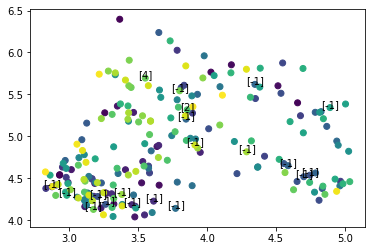

In [30]:
data=input_data_new['embedding'].values.tolist()
labels=hdbscan_cluster_cross_labels
vis_mapping(umap_model_base, data, labels, n_components=2)

In [ ]:
#finding outliers
output_new_outliers=output_new.loc[output_new['cluster_base'].isin([-1])]
output_new_outliers.shape

In [ ]:
#clustered data
output_new_clustered = output_new.loc[~output_new['cluster_base'].isin([-1])]
output_new_clustered.sort_values(by='cluster_base')[0:10]


# Topic Modelling

In [708]:
output_new.sample()

,index,date,content,content_clean,complaint,topic,embedding,cluster_base,cluster,cluster_probability,outlier_score
106,387,2021-01-28 05:22:27,@mebank why is your internet banking not worki...,why is your internet banking not working..?,1,problem/system down,"[0.11206628, -0.11918804, 0.06257193, 0.036132...",-1,5,1.0,0.193059


In [709]:
def get_docs_per_topic(df):
	docs_df= pd.DataFrame()
	docs_df['Doc']=df['content']
	docs_df['Doc_Clean']=df['content_clean']
	docs_df['Topic'] = df['cluster']
	docs_df['Doc_ID'] = range(len(docs_df))
	docs_per_topic_raw = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
	docs_per_topic_clean = docs_df.groupby(['Topic'], as_index = False).agg({'Doc_Clean': ' '.join})
	docs_per_topic=pd.merge(docs_per_topic_raw, docs_per_topic_clean, on=["Topic"])
	
	return docs_df, docs_per_topic


docs_df_base, docs_per_topic_base=get_docs_per_topic(output_base)
docs_df_new, docs_per_topic_new=get_docs_per_topic(output_new)
#doc_df_1year, docs_per_topic_1year=get_docs_per_topic(results_1year)

In [997]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    #count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents) #'english'
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


tf_idf_base, count_base = c_tf_idf(docs_per_topic_base.Doc_Clean.values, m=len(docs_df_base))
tf_idf_new, count_new = c_tf_idf(docs_per_topic_new.Doc_Clean.values, m=len(docs_df_new))
#tf_idf_1year, count_1year = c_tf_idf(docs_per_topic_1year.Doc_Clean.values, m=len(results_1year))

In [998]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc_Clean
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc_Clean": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


top_n_words_base = extract_top_n_words_per_topic(tf_idf_base, count_base, docs_per_topic_base, n=10)
topic_sizes_base = extract_topic_sizes(docs_df_base)

top_n_words_new = extract_top_n_words_per_topic(tf_idf_new, count_new, docs_per_topic_new, n=10)
topic_sizes_new = extract_topic_sizes(docs_df_new)

In [999]:
top_n_words_base[4]

[('app', 0.09593562961761153),
 ('new', 0.05098628450149186),
 ('slow', 0.04281343401043141),
 ('account', 0.0329269938505208),
 ('log', 0.032110075507823556),
 ('accounts', 0.03087025407986162),
 ('still', 0.02974199929253692),
 ('cant', 0.029281923207851036),
 ('working', 0.029281923207851036),
 ('time', 0.027842021738263927)]

In [39]:
np.array(top_n_words_base[4])[:,0]
#list(np.array(top_n_words[-1])[:,1])

array(['app', 'new', 'slow', 'just', 'account', 'log', 'accounts',
       'working', 'time', 'really'], dtype='<U32')

In [40]:
# Creating a variable to save results
clustering_results_base=docs_per_topic_base

clustering_results_base['cluster_size']=topic_sizes_base['Size']

for i,topic in enumerate(clustering_results_base['Topic']):
	clustering_results_base.loc[i,'top_words']=str(list(np.array(top_n_words_base[topic])[:,0]))
	clustering_results_base.loc[i,'top_words_score']=str(top_n_words_base[topic])

clustering_results_base

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score
0,-1,i can update my mobile phone number at ing onl...,i can update my mobile phone number at ing onl...,16,"['cool', 'thats', 'stop', 'rules', 'following'...","[('cool', 0.071140348698617), ('thats', 0.0621..."
1,0,"@mebank Hi Kady, I called ME yesterday after u...","hi kady, i called me yesterday after ur messag...",6,"['tap', 'amp', 'people', 'purchases', 'ur', 'l...","[('tap', 0.20564879819617332), ('amp', 0.13993..."
2,1,@mebank I have wasted 95minutes on hold to @me...,i have wasted minutes on hold to today &amp; n...,6,"['logon', 'mebank', 'code', 'sends', 'memberse...","[('logon', 0.1454672634217419), ('mebank', 0.1..."
3,2,But not the ones who had their Super invested ...,but not the ones who had their super invested ...,93,"['hold', 'service', 'customer', 'bank', 'phone...","[('hold', 0.03595388409495739), ('service', 0...."
4,3,@mebank hey I just received my new card but th...,hey i just received my new card but the sticky...,8,"['card', 'replacement', 'received', 'expiring'...","[('card', 0.14767586173647043), ('replacement'..."
5,4,@mebank I think you have an issue with your Cr...,i think you have an issue with your create new...,40,"['app', 'new', 'slow', 'just', 'account', 'log...","[('app', 0.10577042336951367), ('new', 0.05621..."


In [41]:
# Creating a variable for results
clustering_results_new=docs_per_topic_new

clustering_results_new['cluster_size']=topic_sizes_new['Size']

for i,topic in enumerate(clustering_results_new['Topic']):
	clustering_results_new.loc[i,'top_words']=str(list(np.array(top_n_words_new[topic])[:,0]))
	clustering_results_new.loc[i,'top_words_score']=str(top_n_words_new[topic])

clustering_results_new

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score
0,-1,Working beautifully @mebank (not really). I j...,working beautifully (not really). i just sat o...,5,"['pay', 'thanks', 'hey', 'shift', 'eating', 'g...","[('pay', 0.2441087269839572), ('thanks', 0.177..."
1,0,"@mebank @mebank, will this mean improved servi...",", will this mean improved service? i hope so. ...",104,"['hold', 'bank', 'customer', 'service', 'rate'...","[('hold', 0.036688868213687165), ('bank', 0.03..."
2,1,@EllisonAmy @mebank How bad is that app! So sl...,how bad is that app! so slow the worsttttttttt...,19,"['new', 'app', 'slow', 'transfer', 'need', 'pa...","[('new', 0.07987725752786123), ('app', 0.07863..."
3,2,@mebank Will he spend some money fixing the ap...,"will he spend some money fixing the app, and m...",3,"['money', 'payments', 'painful', 'overnight', ...","[('money', 0.24081925510593852), ('payments', ..."
4,3,"Oh man, it took so long to receive the SMS tha...","oh man, it took so long to receive the sms tha...",5,"['sms', 'like', 'minutes', 'sending', 'receive...","[('sms', 0.22900921809835156), ('like', 0.1487..."
5,4,"@mebank No, it‚Äôs still down. Can you please ...","no, its still down. can you please provide upd...",4,"['bullshit', 'oh', 'information', 'provide', '...","[('bullshit', 0.5370638028127662), ('oh', 0.46..."
6,5,"@mebank hi there, I'm looking to use the mobil...","hi there, i'm looking to use the mobile app bu...",75,"['app', 'internet', 'banking', 'working', 'log...","[('app', 0.07262285046346513), ('internet', 0...."


In [812]:
# if using gensim for cluster summary
#!pip install gensim==3.8.3

In [ ]:
# if using pysummarization for cluster summary
#!pip install pysummarization

In [45]:
# CREATING SUMMARY FOR TOPIC CLUSTERS (Possible solutions: gensim, pysummarization, transformers summerization, ... )

#from gensim.summarization.summarizer import summarize as gensim_summarize	
from pysummarization.nlpbase.auto_abstractor import AutoAbstractor
from pysummarization.tokenizabledoc.simple_tokenizer import SimpleTokenizer
from pysummarization.abstractabledoc.top_n_rank_abstractor import TopNRankAbstractor
from operator import itemgetter


def get_summary(text):
	
	#using gensim -> depreciated: did not work properly, suggested to use version 3.4 or less
	#text_summary=summarize(text, ratio=0.2, word_count=None, split=False)

	#using pysummerization library
	# Object of automatic summarization.
	auto_abstractor = AutoAbstractor()
	# Set tokenizer.
	auto_abstractor.tokenizable_doc = SimpleTokenizer()
	# Set delimiter for making a list of sentence.
	auto_abstractor.delimiter_list = [".", "\n"]
	# Object of abstracting and filtering document.
	abstractable_doc = TopNRankAbstractor()

	# Summarize document.
	result_dict = auto_abstractor.summarize(text, abstractable_doc)
	
	# Extracting the highest score sentence
	max_index=max(result_dict['scoring_data'],key=itemgetter(1))[0]
	max_sen=result_dict['summarize_result'][max_index]

	return max_sen


# there is an issue with length of bigger length of Doc.
for i,doc in enumerate(clustering_results_base['Doc_Clean']):
	clustering_results_base.loc[i,'summary_pysummarization']=get_summary(doc[:200])

# there is an issue with length of bigger length of Doc.
for i,doc in enumerate(clustering_results_new['Doc_Clean']):
	clustering_results_new.loc[i,'summary_pysummarization']=get_summary(doc[:200])

In [42]:
# SUMMARY USING TRANSFORMERS
from transformers import pipeline
summerizer=pipeline('summarization')

for i,doc in enumerate(clustering_results_base['Doc_Clean']):
	clustering_results_base.loc[i,'summary_transformers']=summerizer(doc[:1024], max_length=50, min_length=5, do_sample=False)[0]['summary_text']


for i,doc in enumerate(clustering_results_new['Doc_Clean']):
	clustering_results_new.loc[i,'summary_transformers']=summerizer(doc[:1024], max_length=50, min_length=5, do_sample=False)[0]['summary_text']

Your max_length is set to 50, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


In [222]:
clustering_results_new.sample()

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,cluster_embedding
6,5,"@mebank hi there, I'm looking to use the mobil...","hi there, i'm looking to use the mobile app bu...",75,"['app', 'internet', 'banking', 'working', 'log...","[('app', 0.07262285046346513), ('internet', 0....",i'm not sure that you can actually address th...,[ 4.48030941e-02 -2.49720272e-02 -1.23822475e-...


In [253]:
i=3
topic=1

best_tweets=output_base[output_base['cluster'].isin([topic]) & output_base['cluster_probability'].isin([1.0, 0.0])]
best_embedding=best_tweets['embedding'].mean().tolist()


In [254]:
cluster_embedding_base=pd.DataFrame(columns=['cluster_embedding'])


In [255]:
cluster_embedding_base.loc[i,'cluster_embedding']=best_embedding

cluster_embedding_base

,cluster_embedding
3,"[-0.06209000200033188, -0.04418781399726868, 0..."


In [279]:
cluster_embedding_base=pd.DataFrame(columns=['cluster_embedding'])

for i,topic in enumerate(clustering_results_base['Topic']):
	best_tweets=output_base[output_base['cluster'].isin([topic]) & output_base['cluster_probability'].isin([1.0, 0.0])]
	best_embedding=best_tweets['embedding'].mean()
	cluster_embedding_base.loc[i,'cluster_embedding']=best_embedding
	best_tweet=best_tweets.sample(1)['content_clean'].values[0]
	clustering_results_base.loc[i,'sample_tweet']=best_tweet

clustering_results_base['cluster_embedding']=cluster_embedding_base

cluster_embedding_new=pd.DataFrame(columns=['cluster_embedding'])

for i,topic in enumerate(clustering_results_new['Topic']):
	best_tweets=output_new[output_new['cluster'].isin([topic]) & output_new['cluster_probability'].isin([1.0, 0.0])]
	best_embedding=best_tweets['embedding'].mean()
	cluster_embedding_new.loc[i,'cluster_embedding']=best_embedding
	best_tweet=best_tweets.sample(1)['content_clean'].values[0]
	clustering_results_new.loc[i,'sample_tweet']=best_tweet

clustering_results_new['cluster_embedding']=cluster_embedding_new


In [281]:
clustering_results_base


,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,cluster_embedding,sample_tweet
0,-1,i can update my mobile phone number at ing onl...,i can update my mobile phone number at ing onl...,16,"['cool', 'thats', 'stop', 'rules', 'following'...","[('cool', 0.071140348698617), ('thats', 0.0621...",i can update my mobile phone number at ing on...,"[-0.004731265, 0.008409454, -0.01706773, 0.056...","hi there, im trying to fill in an enquiry onli..."
1,0,"@mebank Hi Kady, I called ME yesterday after u...","hi kady, i called me yesterday after ur messag...",6,"['tap', 'amp', 'people', 'purchases', 'ur', 'l...","[('tap', 0.20564879819617332), ('amp', 0.13993...",i just got a text reminding me to tap&amp;go ...,"[0.03829834, -0.065923855, 0.051059283, 0.0243...",) hey guys. i just got a text reminding me to ...
2,1,@mebank I have wasted 95minutes on hold to @me...,i have wasted minutes on hold to today &amp; n...,6,"['logon', 'mebank', 'code', 'sends', 'memberse...","[('logon', 0.1454672634217419), ('mebank', 0.1...",i have wasted minutes on hold to today &amp; ...,"[-0.062090002, -0.044187814, 0.010370469, -0.0...",dropping it with faith even do i know am late ...
3,2,But not the ones who had their Super invested ...,but not the ones who had their super invested ...,93,"['hold', 'service', 'customer', 'bank', 'phone...","[('hold', 0.03595388409495739), ('service', 0....",i've been on hold listening to the most annoy...,"[0.0039543877, 0.088679194, -0.032655668, 0.00...",bugger
4,3,@mebank hey I just received my new card but th...,hey i just received my new card but the sticky...,8,"['card', 'replacement', 'received', 'expiring'...","[('card', 0.14767586173647043), ('replacement'...",e-gift code from you that has expired expired...,"[0.08603623, 0.090307325, 0.049070124, -0.0030...","i rang last week, and was told the card had be..."
5,4,@mebank I think you have an issue with your Cr...,i think you have an issue with your create new...,40,"['app', 'new', 'slow', 'just', 'account', 'log...","[('app', 0.10577042336951367), ('new', 0.05621...",i think you have an issue with your create ne...,"[0.060388144, 0.003216993, -0.04273041, 0.0161...",hi there. im having login issues (app and desk...


In [282]:
#SAVING RESULTS
#pickle.dump(clustering_results_base, open(f"../data/mebank_tweets_results_cluster_summary_base.pkl", 'wb'))
#pickle.dump(clustering_results_new, open(f"../data/mebank_tweets_results_cluster_summary_new.pkl", 'wb'))

# Pickle format
clustering_results_base.to_pickle(f"../data/mebank_tweets_results_cluster_summary_base.pkl")
clustering_results_new.to_pickle(f"../data/mebank_tweets_results_cluster_summary_new.pkl")
# CSV format

clustering_results_base.to_csv('../data/mebank_tweets_results_cluster_summary_base.csv', index=False)
clustering_results_new.to_csv('../data/mebank_tweets_results_cluster_summary_new.csv', index=False)

# s3 bucket in Cloud
#clustering_results_2020.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_summary.csv",index=False)

In [283]:
#SAVING RESULTS
#pickle.dump(output_base, open(f"../data/mebank_tweets_results_cluster_mapping_base.pkl", 'wb'))
#pickle.dump(output_new, open(f"../data/mebank_tweets_results_cluster_mapping_new.pkl", 'wb'))

# Pickle format
output_base.to_pickle("../data/mebank_tweets_results_cluster_mapping_base.pkl")
output_new.to_pickle("../data/mebank_tweets_results_cluster_mapping_base.pkl")

# CSV format
output_base.to_csv('../data/mebank_tweets_results_cluster_mapping_base.csv', index=False)
output_new.to_csv('../data/mebank_tweets_results_cluster_mapping_new.csv', index=False)

# s3 bucket in Cloud
#results_cluster_sorted.to_csv(f"{s3_data_dir}/results/mebank_tweets_cluster_mapping.csv",index=False)

# Analysis and plotting

In [351]:
# importing tweets and their embeddings
tweets_base=pd.read_csv('../data/mebank_tweets_base_results_cluster_mapping.csv')
tweets_new=pd.read_csv('../data/mebank_tweets_new_results_cluster_mapping.csv')

tweets_new.head(1)

,index,date,content,content_clean,complaint,topic,embedding,cluster_new,cluster_base,cluster_probability,outlier_score,cluster
0,718,2021-06-03 04:26:32,Working beautifully @mebank (not really). I j...,working beautifully (not really). i just sat o...,1,problem/customer service,[ 4.51719314e-02 8.26158002e-02 -8.72131214e-...,-1,-1,0.0,0.032713,-1


In [352]:
clusters_base=pd.read_csv('../data/mebank_tweets_base_results_cluster_summary.csv')
clusters_new=pd.read_csv('../data/mebank_tweets_new_results_cluster_summary.csv')

clusters_new.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_pysummarization,summary_transformers,sample_tweet
0,-1,Working beautifully @mebank (not really). I j...,working beautifully (not really). i just sat o...,5,"['pay', 'thanks', 'hey', 'shift', 'eating', 'g...","[('pay', 0.2441087269839572), ('thanks', 0.177...",thanks a lot.\n,Stuck once again due to your app and web serv...,['hey why is your system down i need to pay fo...


In [354]:
#clean data for saving
tweets_base_output=tweets_base[['date','content','complaint','topic','cluster']]
tweets_new_output=tweets_new[['date','content','complaint','topic','cluster']]

tweets_base_output.head(1)

,date,content,complaint,topic,cluster
0,2020-09-16 04:44:14,i can update my mobile phone number at ing onl...,1,problem/others,-1


In [209]:
topwords_base=ast.literal_eval(clusters_base.loc[1,'top_words'])[:10]
topwords_new=ast.literal_eval(clusters_new.loc[1,'top_words'])[:10]


In [212]:
for i,topic in enumerate(tweets_base['cluster']):
	x=clusters_base.loc[clusters_base['Topic']==topic,'top_words']
	tweets_base.loc[i,'top_words']=x.values

for i,topic in enumerate(tweets_new['cluster']):
	x=clusters_new.loc[clusters_new['Topic']==topic,'top_words']
	tweets_new.loc[i,'top_words']=x.values

In [ ]:
tweets_base.to_csv('../data/results_tweets_base.csv')
tweets_new.to_csv('../data/results_tweets_new.csv')

tweets_base.sample(3)

In [220]:
clusters_base_output=clusters_base[['Topic','cluster_size','top_words','summary_transformers','sample_tweet']]
clusters_new_output=clusters_new[['Topic','cluster_size','top_words','summary_transformers','sample_tweet']]

clusters_new_output


,Topic,cluster_size,top_words,summary_transformers,sample_tweet
0,-1,5,"['pay', 'thanks', 'hey', 'shift', 'eating', 'g...",Stuck once again due to your app and web serv...,['hey why is your system down i need to pay fo...
1,0,104,"['hold', 'bank', 'customer', 'service', 'rate'...","i wouldnt worry about network disruption, its...",if the app wasn't enough of a reason to ditch ...
2,1,19,"['new', 'app', 'slow', 'transfer', 'need', 'pa...",The monochrome theme makes it more difficult ...,you're not the only one. the updated app is co...
3,2,3,"['money', 'payments', 'painful', 'overnight', ...","Will he spend some money fixing the app, and ...",when are you guys going to enable sending mone...
4,3,5,"['sms', 'like', 'minutes', 'sending', 'receive...",i tested it - when there is one word in the f...,like it seriously looks like they expect that ...
5,4,4,"['bullshit', 'oh', 'information', 'provide', '...","it isn't back up. it is down again. no, its s...",oh yes. just that its down again
6,5,75,"['app', 'internet', 'banking', 'working', 'log...",i've been getting this message every time i t...,hello! somehow my app has turned off balance p...


In [221]:
clusters_base_output.to_csv('../data/results_clusters_base.csv')
clusters_new_output.to_csv('../data/results_clusters_new.csv')

In [882]:
#importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set(font_scale=1)

In [1011]:
clusters_2020.head(1)

,Topic,Doc,Doc_Clean,cluster_size,top_words,top_words_score,summary_transformers,sample_tweet
0,-1,@BroHilderchump I would recommend Mebank (owne...,i would recommend mebank (owned by industry su...,108,"['money', 'new', 'days', 'card', 'customer', '...","[('money', 0.011815373834246379), ('new', 0.01...",i would recommend mebank (owned by industry s...,same bro worst new year ever


In [226]:
#data=clusters.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

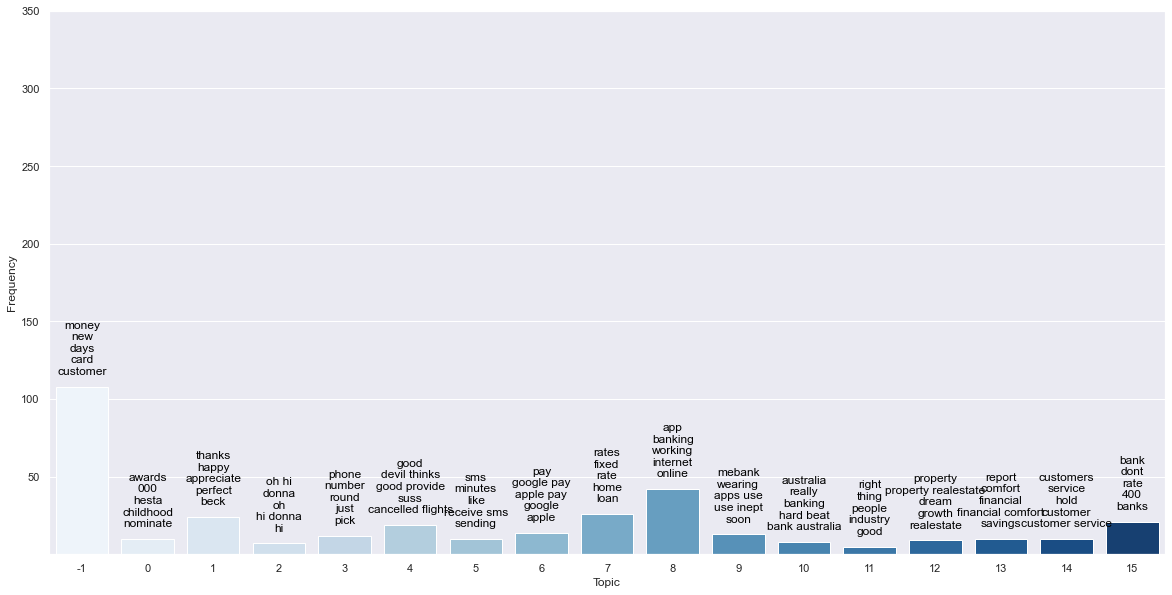

In [886]:
#plotting topics in the period 

data=clusters_2020.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

ax = sns.barplot(x="Topic", y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.yaxis.set_ticks([50,100,150,200,250,300,350])


fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.savefig("cluster_freqs.png")


for i in range(len(clusters_2020['Topic'])):

    n_topwords=5
    topwords=clusters_2020.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(clusters_2020.loc[i,'Topic']+1, clusters_2020.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2020.png")

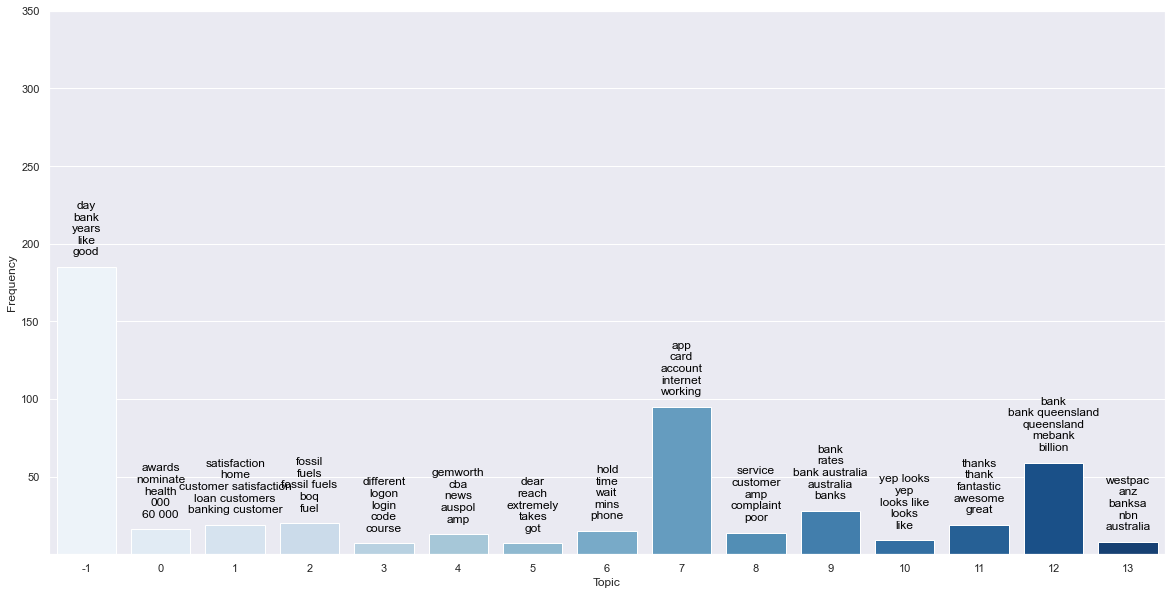

In [887]:
#plotting topics in the period 

data=clusters_2021.loc[:,['Topic','cluster_size']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

ax = sns.barplot(x="Topic", y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.yaxis.set_ticks([50,100,150,200,250,300,350])


fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)
fig.savefig("cluster_freqs.png")


for i in range(len(clusters_2021['Topic'])):

    n_topwords=5
    topwords=clusters_2021.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(clusters_2021.loc[i,'Topic']+1, clusters_2021.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=12,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2021.png")

In [952]:
data=clusters_2020.loc[:,['Topic','cluster_size','top_words']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

for i,topic in enumerate(data['Topic']):
    data.loc[i,'index']=i

data=data[1:12]

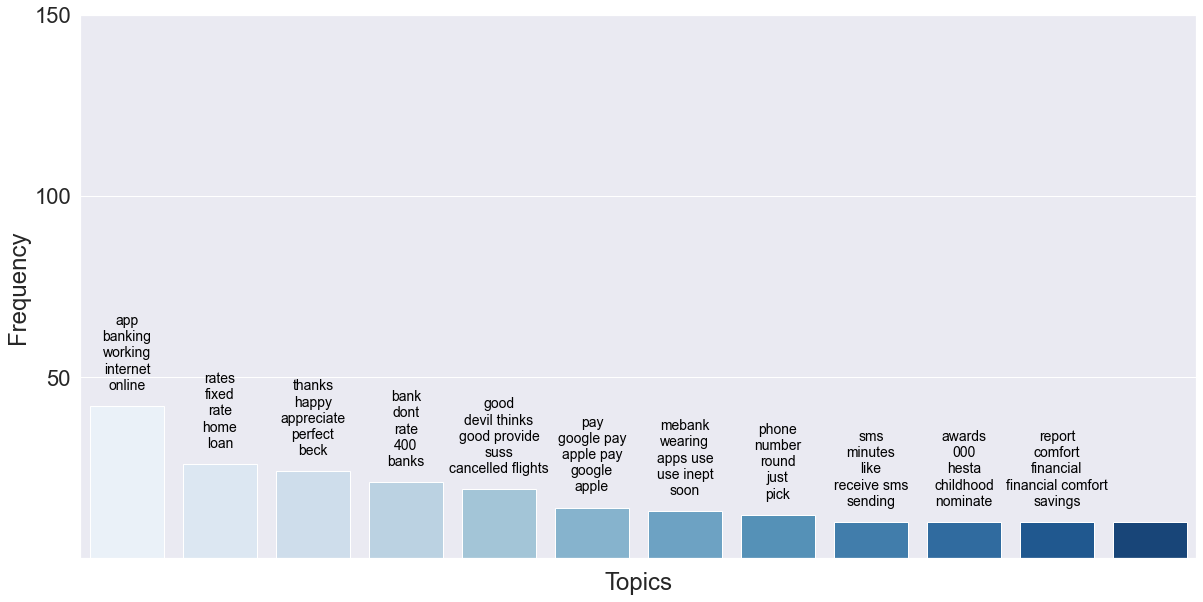

In [999]:
#plotting topics in the period 
ax = sns.barplot(x='index',y="cluster_size", data=data, palette = "Blues")
ax.yaxis.set_label_text('Frequency')
ax.xaxis.set_label_text('Topics')
ax.set(xticklabels=[])

sns.set(font_scale=2) 
ax.yaxis.set_ticks([50,100,150])

fig = ax.get_figure()
fig.set_figheight(10)
fig.set_figwidth(20)


for i in range(1,len(data['Topic'])): 

    #label='{}'.format(data.loc[i,'Topic'])
    n_topwords=5
    topwords=data.loc[i,'top_words']
    topwords=ast.literal_eval(topwords)[:n_topwords]

    label=''
    for idx in range(n_topwords):
        label=label+f"{topwords[idx]}\n"

    plt.annotate(label, # this is the text
                 xy=(data.loc[i,'index']-1, data.loc[i,'cluster_size']), # these are the coordinates to position the label
                 color='black',
                 size=14,
                 textcoords="offset points", # how to position the text
                 xytext=(0,0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

fig.savefig("cluster_freqs_2020.png")

In [1216]:
data=clusters_2020.loc[:,['Topic','cluster_size','top_words_score']].sort_values(by='cluster_size', ascending=False, ignore_index=True).reset_index(drop=True)

for i,topic in enumerate(data['Topic']):
    data.loc[i,'index']=i

data=data[1:13]
data

,Topic,cluster_size,top_words_score,index
1,8,42,"[('app', 0.06068483574541008), ('banking', 0.0...",1.0
2,7,26,"[('rates', 0.06159444333567206), ('fixed', 0.0...",2.0
3,1,24,"[('thanks', 0.1365620242497388), ('happy', 0.0...",3.0
4,15,21,"[('bank', 0.056224391764267405), ('dont', 0.02...",4.0
5,4,19,"[('good', 0.07136941498501952), ('devil thinks...",5.0
6,6,14,"[('pay', 0.07954368238745381), ('google pay', ...",6.0
7,9,13,"[('mebank', 0.15648961160490152), ('wearing', ...",7.0
8,3,12,"[('phone', 0.07842681681706848), ('number', 0....",8.0
9,5,10,"[('sms', 0.10348738736969179), ('minutes', 0.0...",9.0
10,0,10,"[('awards', 0.06922543370894715), ('000', 0.06...",10.0


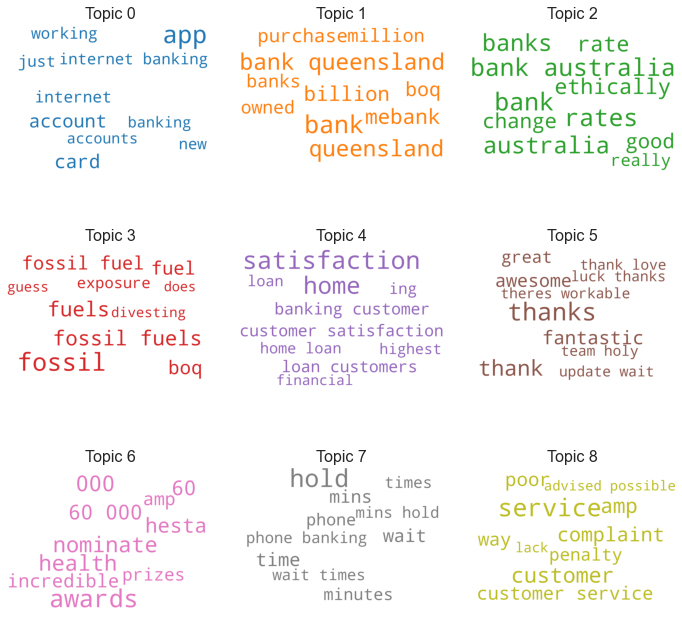

In [1024]:
# Wordcloud of Top N words in each topic
#!pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


fig, axes = plt.subplots(3,3 , figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(ast.literal_eval(data.loc[i+1,'top_words_score'])[:10])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

fig.savefig("wordcloud_2021.png")


# Cluster similarities

Similarity based on tags

In [ ]:
# Similarity Score based on TAGS (top keywords)
topic_similarities = cosine_similarity(tf_idf_base.T)

Similarity based on embeddings in the original space

In [553]:
#concating clusters for comparision
cluster_base=clustering_results_base['cluster_embedding'][1:]
cluster_new=clustering_results_new['cluster_embedding'][1:]
clusters_all=pd.concat([cluster_base, cluster_new], axis = 0)

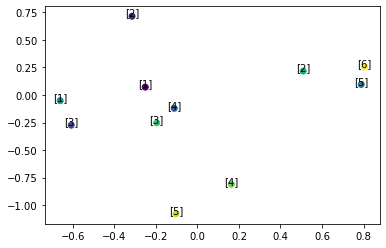

In [554]:
# visualizing clusters
data = list(clusters_all.values)
labels = np.array(clusters_all.index)
vis_mapping(data, labels=labels, model=pca_model_new, n_components=2, n_samples=11)

In [518]:
clustering_results_base['top_words'], clustering_results_new['top_words']

(0    ['cool', 'thats', 'stop', 'rules', 'following'...
 1    ['tap', 'amp', 'people', 'purchases', 'ur', 'l...
 2    ['logon', 'mebank', 'code', 'sends', 'memberse...
 3    ['hold', 'service', 'customer', 'bank', 'phone...
 4    ['card', 'replacement', 'received', 'expiring'...
 5    ['app', 'new', 'slow', 'just', 'account', 'log...
 Name: top_words, dtype: object,
 0    ['pay', 'thanks', 'hey', 'shift', 'eating', 'g...
 1    ['hold', 'bank', 'customer', 'service', 'rate'...
 2    ['new', 'app', 'slow', 'transfer', 'need', 'pa...
 3    ['money', 'payments', 'painful', 'overnight', ...
 4    ['sms', 'like', 'minutes', 'sending', 'receive...
 5    ['bullshit', 'oh', 'information', 'provide', '...
 6    ['app', 'internet', 'banking', 'working', 'log...
 Name: top_words, dtype: object)

In [1060]:
cluster_base=clustering_results_base['cluster_embedding'][1:]
cluster_new=clustering_results_new['cluster_embedding'][1:]
embedding_similarity = cosine_similarity(list(cluster_new.values),list(cluster_base.values))
embedding_similarity

array([[0.5816018 , 0.7947639 , 0.9776095 , 0.53863025, 0.58745384],
       [0.4259555 , 0.52402645, 0.52637637, 0.34223378, 0.8696913 ],
       [0.5673036 , 0.5362542 , 0.61111724, 0.3924018 , 0.59656394],
       [0.37395787, 0.38592556, 0.5443845 , 0.4087142 , 0.54493314],
       [0.18174869, 0.21098892, 0.35582688, 0.16064894, 0.19746354],
       [0.5003811 , 0.67408633, 0.62398267, 0.4800738 , 0.8640251 ]],
      dtype=float32)

# Updating clusters (Merging similar clusters and adding new clusters to the dictionary)

Finding topic mappings based on similarity metric (in the original sematic embedding space)

In [775]:
def get_intercluster_topic_mapping(cluster_new, cluster_base, topic_column='cluster, 'similarity_thr=0.85):
    '''
        Compares a new cluster with a base cluster and returns a mapping of cluster indexes to be merged
        
        Params: 
            cluster_base: base cluster (dataframe: cluster index and cluste embedding)
            cluster_new: base cluster (dataframe: cluster index and cluste embedding)
            similarity_thr: similarity threshhold for merging
    '''    
    Topic
    map_topics = dict()

    embeddings_base = cluster_base.loc[cluster_base[topic_column] != -1, 'cluster_embedding']
    embeddings_new = cluster_new.loc[cluster_new[topic_column] != -1, 'cluster_embedding']
    embedding_similarity = cosine_similarity(list(embeddings_new.values),list(embeddings_base.values))


    for i,embedding in enumerate(embeddings_new):
        topic_to_merge = cluster_new.Topic[embeddings_new.index[i]]
        #print('topic_to_merge:', topic_to_merge)
        index_topic_to_merge_into=np.argmax(embedding_similarity[i])
        topic_to_merge_into = cluster_base.Topic[embeddings_base.index[index_topic_to_merge_into]]
        #print('topic_to_merge_into:', topic_to_merge_into)
        similarity_score=embedding_similarity[i,index_topic_to_merge_into]
        #print('similarity score:', similarity_score)

        if similarity_score >= similarity_thr:
            map_topics.update({topic_to_merge: topic_to_merge_into})

    print('topics to merge:', map_topics)
    return map_topics
    

get_intercluster_topic_mapping(clustering_results_new, clustering_results_base, similarity_thr=0.85)

topics to merge: {0: 2, 1: 4, 5: 4}


{0: 2, 1: 4, 5: 4}

In [793]:
def get_intracluster_topic_mapping(cluster, similarity_thr=0.80):
    '''
        compares topics in a cluster and returns a mapping of cluster to be merged
        Params: 
            cluste: cluster (dataframe: cluster index and cluste embedding)
            similarity_thr: similarity threshhold for merging
    '''    
    map_clusters=dict()

    # extracting embeddings
    embeddings = cluster.loc[cluster.Topic != -1, 'cluster_embedding']

    # calculating similarity matrix
    embedding_similarity = cosine_similarity(list(embeddings.values))
    np.fill_diagonal(embedding_similarity, 0)
    embedding_similarity=np.triu(embedding_similarity)

    for i,embedding in enumerate(embeddings):
        topic_to_merge = cluster.Topic[embeddings.index[i]]
        #print('topic_to_merge:', topic_to_merge)
        index_topic_to_merge_into=np.argmax(embedding_similarity[i])
        topic_to_merge_into = cluster.Topic[embeddings.index[index_topic_to_merge_into]]
        #print('topic_to_merge_into:', topic_to_merge_into)
        similarity_score=embedding_similarity[i,index_topic_to_merge_into]
        #print('similarity score:', similarity_score)

        if similarity_score >= similarity_thr:
            map_clusters.update({topic_to_merge: topic_to_merge_into})

    print('clusters to merge:', map_clusters)
    return map_clusters
    

get_intracluster_topic_mapping(clustering_results_new, similarity_thr=0.65)

clusters to merge: {1: 5}


{1: 5}

In [1064]:
def get_ordered_intracluster_topic_mapping(cluster, similarity_thr=0.80, starting_index=1):
	'''
	Generates the mapping for cluster merge
	Params: 
		cluster:        cluster (df with Topic column)
		similarity_thr: similarity threshold for merging
		starting_index: starting topic number for re-mapped topics
	'''   

	map_topic = get_intracluster_topic_mapping(cluster, similarity_thr=similarity_thr)
	
	old_topics = cluster.Topic[cluster.Topic != -1]

	merged_topics = topics.apply(lambda x: map_topic[x] if (x in map_topic) else x)

	new_topics_unique = np.unique(merged_topics)
	target_topics=np.array(range(starting_index,len(new_topics_unique)+1))
	map_to_target=dict(zip(new_topics_unique,target_topics))

	new_topics = merged_topics.map(map_to_target)
	
	final_map = dict(zip(old_topics.values,new_topics.values))

	final_map.update({-1:-1})

	return final_map

In [1065]:
# testing the function
cluster_new_test=clustering_results_new.copy() 
map_topic_test = get_ordered_intracluster_topic_mapping(cluster_new_test, similarity_thr=0.65)
map_topic_test

clusters to merge: {1: 5}


{0: 1, 1: 5, 2: 2, 3: 3, 4: 4, 5: 5, -1: -1}

In [1062]:
def get_ordered_intercluster_topic_mapping(cluster_new, cluster_base, topic_column='cluster', similarity_thr=0.80):
	'''
	Generates the mapping for merging the new clustering outcome with base clusters
	Params:
		cluster_new:  new clusters (df with Topic column)
		cluster_base: base clusters (df with Topic column)
		similarity_thr: similarity threshold for merging
	'''   	

	starting_index = max(cluster_base[topic_column]) + 1
	map_topic = get_intercluster_topic_mapping(cluster_new, cluster_base, topic_column=topic_column, similarity_thr=similarity_thr)

	# new cluster's topic list
	old_topics = cluster_new.Topic[cluster.Topic != -1]

	# new topics to be created (for merged cluster)
	n_target_topics = len(old_topics) - len(map_topic)
	target_topics = np.array(range(starting_index, starting_index + n_target_topics))

	# new cluster's topics to be re-mapped
	new_topics = [old_topic for old_topic in old_topics if old_topic not in map_topic]

	# mapping from new cluster's old topic to corresponding target topic in the base cluster
	map_new_topics=dict(zip(new_topics,target_topics))

	# updating the mapping by adding the mapping for emerging clusters
	map_topic.update(map_new_topics)

	# adding the mapping for outliers (-1)  
	map_topic.update({-1:-1})


	return map_topic

In [1063]:
# testing the function
cluster_base_test=clustering_results_base.copy() 
cluster_new_test=clustering_results_new.copy() 
map_topic_test = get_ordered_intercluster_topic_mapping(cluster_new_test, cluster_base_test, similarity_thr=0.90)
map_topic_test

topics to merge: {0: 2}


{0: 2, 1: 5, 2: 6, 3: 7, 4: 8, 5: 9, -1: -1}

Re-mapping topics in cluster list and datasets using calculated topic mapping (can be used for both cluster optimization and merging results)

In [1286]:
def remap_topics(map_topic, data=None, cluster=None, update_summary_columns=False, n_topwords=10):
	'''
	Remaps topics in a cluster and returns updated cluster list, docs_df, and c_tf_idf, top_n_words
	Params: 
		map_topic: 	mapping of clusters to be merged
		data:		list of data dataframes to be remapped
		cluster: 	cluster list (df with column Topic) to be remapped
		update_c_tf_idf: update c_tf_idf and docs if True 
		doc_column: 	column indicating document column (typically Doc or Doc_Clean)
		n_topwords: 	number of top words (tags) to be returned
	'''   
	
	for topic_to_merge in map_topic:
		topic_to_merge_into = map_topic[topic_to_merge]
		print(f"mapping {topic_to_merge} -> {topic_to_merge_into}")


	# Adjust Topic columns for datapoints
	if data is not None:
		for i,docs_df in enumerate(data):
			docs_df['Topic'] = docs_df['Topic'].map(map_topic)


	# Adjust Topic colum in cluster dataframe and aggregate clusters
	if cluster is not None:
		cluster['Topic'] = cluster['Topic'].map(map_topic)
		if update_summary_columns is  True:
			# updating columns (to be improved)
			cluster_output = cluster.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join,
										'Doc_Clean': ' '.join,
										'cluster_size': sum,
										'cluster_embedding' : np.mean,
										'top_words': 'first',
										'top_words_score': 'first',
										'summary_transformers':'first',
										'sample_tweet':'first',
										})
			
			# Calculate new topic words
			#m = len(docs_df)
			#docs_per_topic = data.groupby(['Topic'], as_index = False).agg({doc_column: ' '.join})
			#tf_idf, count = c_tf_idf(docs_per_topic[doc_column].values, m)
			#top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n_topwords)

	return cluster_output


In [1287]:
#testing the function
cluster_test=clustering_results_new.copy() 
docs_df_test=docs_df_new.copy()
map_topic_test = get_ordered_intracluster_topic_mapping(cluster_test, similarity_thr=0.65, starting_index=1)

clusters to merge: {1: 5}


In [1288]:
cluster_out = remap_topics(map_topic_test, cluster=cluster_test, data=None, update_summary_columns=True, n_topwords=10)

mapping 0 -> 1
mapping 1 -> 5
mapping 2 -> 2
mapping 3 -> 3
mapping 4 -> 4
mapping 5 -> 5
mapping -1 -> -1


In [1290]:
### NOT used anymore
def merge_intercluster_topics(cluster_new, docs_df_new,cluster_base, docs_df_base, map_topic, doc_column='Doc_Clean', n_topwords=10):
	'''
	Merges topics in a new clustering analysis with base clusters and returns updated cluster list, docs_df, and c_tf_idf, top_n_words
	Params: 
		cluster_new:  	new clusters (df with column Topic)
		cluster_base: 	base clusters (df with column Topic)
		docs_df_new:  	new data (tweets) (df with column Topic)
		docs_df_base: 	base data (tweets) (df with column Topic)
		map_topic:    	mapping of clusters to be merged
		doc_column:   	column indicating document column (typically Doc or Doc_Clean)
		n_topwords:   	number of top words (tags) to be returned
	'''
	
	for topic_to_merge in map_topic:
		topic_to_merge_into = map_topic[topic_to_merge]
		print(f"mapping new clustering's cluster #{topic_to_merge} -> base clustering's cluster #{topic_to_merge_into}")

	# Adjust topics
	docs_df['Topic'] = docs_df['Topic'].map(map_topic)
	cluster['Topic'] = cluster['Topic'].map(map_topic)
	docs_per_topic = cluster.groupby(['Topic'], as_index = False).agg({doc_column: ' '.join})

	# Calculate new topic words
	m = len(docs_df)
	tf_idf, count = c_tf_idf(docs_per_topic[doc_column].values, m)
	top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n_topwords)

	return tf_idf, count, docs_per_topic, top_n_words

# Reducing the number of clusters

Approach 1 (to be used): merge topics based on their similarity score (average embedding of top representiative data points)

Approach 2 (not recommended): merge smallest clusters with their most similar cluster 

In [1000]:
def merge_smallest_topic(data, docs_df, tf_idf):   
    #need to modify to update tweet and clsuter datasets to include new cluster names 
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)

    return tf_idf, count, top_n_words

#topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

# Predicting clusters for new data points 

First, predicting cluster using base models

In [77]:
data_new = input_data_new.copy()
data_new.sample()

,index,date,content,content_clean,complaint,topic,embedding
151,606,2021-04-08 23:13:52,@mebank is there an issue with your app loggin...,is there an issue with your app logging in to ...,1,problem/system down,"[0.010991459, -0.26702502, 0.07868806, 0.05327..."


In [78]:
# Lower-dimentional mapping using base model's reduction model
projections_cross=reducer_base.transform(input_data_new['embedding'].values.tolist())

In [79]:
# Predict cluster membership using the base hdbscan model
hdbscan_clusterer_predicted_labels, hdbscan_clusterer_predicted_strengths = hdbscan.approximate_predict(hdbscan_clusterer_base, projections_cross)
data_new['cluster'] = hdbscan_clusterer_predicted_labels

data_new.sample()

,index,date,content,content_clean,complaint,topic,embedding,cluster
38,139,2020-09-28 11:06:58,@mebank wtf these muppets don‚Äôt even know w...,wtf these muppets dont even know what they don...,1,problem/financial products,"[-0.11908117, 0.24669078, 0.048636213, -0.0010...",-1


In [80]:
#clustered data
data_new_clustered = data_new.loc[~data_new['cluster'].isin([-1])]
data_new_clustered.sort_values(by='cluster').sample()

,index,date,content,content_clean,complaint,topic,embedding,cluster
96,341,2021-01-02 03:00:07,@mebank @M1ssB4d True app is not working. Can...,true app is not working. can login but cant ch...,1,problem/app,"[0.020505058, 0.080376916, -0.022331264, 0.089...",4


In [81]:
#clustered data
data_new_unclustered = data_new.loc[data_new['cluster'].isin([-1])]
data_new_unclustered.sample()

,index,date,content,content_clean,complaint,topic,embedding,cluster
173,685,2021-05-16 09:42:54,@mebank new app is taking about 15 seconds to ...,new app is taking about seconds to log in. not...,1,problem/app,"[0.075530514, -0.009137764, -0.023845961, -0.0...",-1


Then, create a new model to cluster unclustred data points

In [82]:
# lower-dimentional projections
projections_new=reducer_base.transform(data_new_unclustered['embedding'].values.tolist())

In [83]:
# clustering
hdbscan_clusterer_new = hdbscan_model_new.fit(projections_new)

In [85]:
hdbscan_clusterer_new.labels_

array([ 0,  0, -1,  1,  0,  1, -1,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  2,  3,  0,  2,  1,  0,  1, -1, -1,  0,  2,  1,
        2, -1,  3,  2,  0,  0,  3,  3,  2,  0,  1,  0,  0,  1,  0,  3,  3,
        2,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  1,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  2,  0,
        0,  0,  2,  2,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  3,
        3,  3,  0,  0,  0,  0,  2,  1,  0,  0,  1,  1,  1, -1,  2,  0,  1,
        0,  1,  2,  2, -1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  1,  1,  0,  0,  0,  0,  2,  0,  0,  0])

In [86]:
hdbscan_clusterer_new.cluster_persistence_

array([0.12904456, 0.11268766, 0.17981826, 0.07841338])

In [ ]:
data_new_unclustered['cluster'] = hdbscan_clusterer_new.labels_

# BERTTopic

In [373]:
from sentence_transformers import SentenceTransformer

#model = SentenceTransformer("paraphrase-mpnet-base-v2")
#embeddings_clean = model.encode(input_data_clean["content_clean"].values)

In [491]:
from bertopic import BERTopic

# Create BERTopic model
topic_model = BERTopic(nr_topics='auto',
		top_n_words=10,
                n_gram_range=(1,2), 
                calculate_probabilities=True,
                embedding_model=SentenceTransformer("paraphrase-mpnet-base-v2"),
                umap_model= umap_model_all,
                hdbscan_model=hdbscan_model_all,
                verbose=True)



docs=input_data['content_clean']
#embeddings=np.array(results_cluster_sorted['embedding'].values.tolist())

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(docs)

Batches: 100%|██████████| 27/27 [00:59<00:00,  2.20s/it]
2021-08-25 03:02:04,991 - BERTopic - Transformed documents to Embeddings
2021-08-25 03:02:07,844 - BERTopic - Reduced dimensionality with UMAP
2021-08-25 03:02:07,954 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-08-25 03:02:24,002 - BERTopic - Reduced number of topics from 26 to 6


In [492]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,491,-1_to_of_for_bank
1,0,155,0_thanks_have_on hold_phone
2,1,107,1_is_your_for_me
3,2,46,2_awards_hesta_the hesta_in prizes
4,3,25,3_fuels_fossil fuels_fuel_fossil fuel
5,4,9,4_timeline_word_ago_years


In [493]:
timestamps=input_data.date.dt.to_period('Q')
tweets=input_data.content_clean.to_list()

topics_over_time = topic_model.topics_over_time(tweets, topics, timestamps)


5it [00:11,  2.29s/it]


In [494]:
topics_over_time.head(50)

,Topic,Words,Frequency,Timestamp
0,-1,"of, and, is, for, it",87,2020Q3
1,0,"thanks, still, on, awesome, still down",24,2020Q3
2,1,"to, on, me, days, transaction",17,2020Q3
3,2,"nominate, childhood, early childhood, 000, tha...",12,2020Q3
4,3,"fossil, fossil fuels, fuels, to fossil, invest in",5,2020Q3
5,4,"wait for, today rather, effective today, farce...",2,2020Q3
6,-1,"of, they, for, bank, me",113,2020Q4
7,0,"you, thanks, have, now, just",41,2020Q4
8,1,"your, have, me, bank, be",28,2020Q4
9,2,"hesta, the hesta, nursing, hestaawards, hestan...",9,2020Q4


In [ ]:
#topic_model.visualize_topics_over_time(topics_over_time)

#topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)

In [404]:
topic_model.visualize_topics()

In [ ]:
# CLUSTER QUALITY METRICS
#from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

#adjusted_rand_score(dataset['topic'], result['labels']), adjusted_mutual_info_score(dataset['topic'], result['labels'])


# Different clustering metrics
sklearn.metrics.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)
sklearn.metrics.rand_score(labels_true, labels_pred)
sklearn.metrics.adjusted_mutual_info_score(labels_true, labels_pred, *, average_method='arithmetic')
sklearn.metrics.calinski_harabasz_score(X, labels)
sklearn.metrics.davies_bouldin_score(X, labels)